<h1>Contextualização</h1>

<h2> Dataset utilizado </h2>
<ul>
    <li>Obtido em <a>https://www.kaggle.com/datasets/mahmoudreda55/satellite-image-classification</a></li>
    <li>Contém <strong>5631</strong> imagens de satélite</li>
    <li>Classes: <strong>nuvem, deserto, vegetação, água</strong></li>
    <li>Resolução das imagens:
        <ul>
            <li>Vegetação e água: <strong>64<i>x</i>64</strong> pixels</li>
            <li>Nuvem e deserto: <strong>256<i>x</i>256</strong> pixels</li>
        </ul>
</ul>

Text(0.5, 1.0, 'Quantidade de imagens de cada classe')

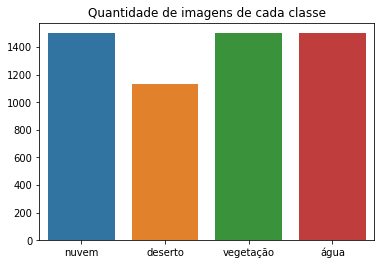

In [80]:
label_names = ["nuvem","deserto","vegetação","água"]
counts = [1500, 1131, 1500, 1500]
sns.barplot(x = label_names, y = counts )
plt.title('Quantidade de imagens de cada classe')

Found 5631 files belonging to 4 classes.


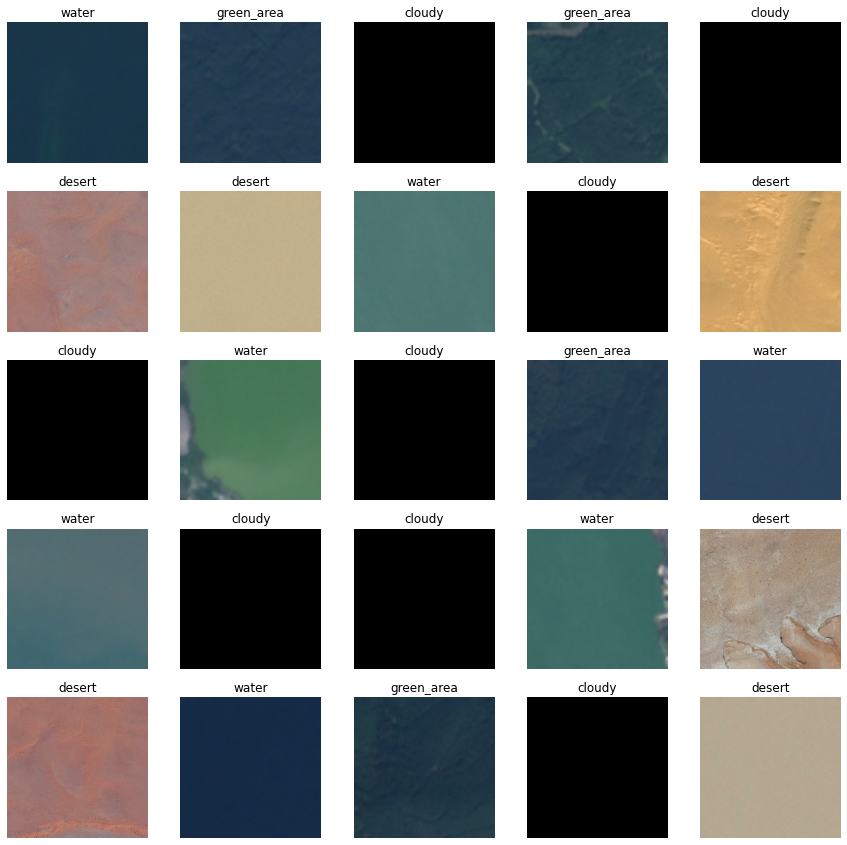

In [81]:
dataset = dataset_from_dir(DATASETDIR, labels = 'inferred', image_size = (256, 256))
plt.figure(figsize = (15,15))
for image , label in dataset.take(1):
    for i in range(25) :
        plt.subplot(5,5,i+1)
        plt.imshow(image[i].numpy().astype("uint8"))
        plt.title(dataset.class_names[label[i]])
        plt.axis("off")

<p style="height: 25px"></p>
<h2>Objetivo</h2>
<p>Dada uma imagem de alguma das quatro classes, predizer a qual das classes ela pertence:</p>
<p style="height: 25px"></p>
<img width="500px" src="./img/objetivo.png"/>
<p style="height: 25px"></p>
<p></p>

<h1>Aplicação</h1>
<ul>
    <li>Modelo baseado no VGG-16</li>
</ul>
<img width='400px' src='./img/modelo.png'/>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import tensorflow as tf
import seaborn as sns
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.utils import image_dataset_from_directory as dataset_from_dir, load_img, img_to_array
from sklearn.metrics import confusion_matrix
from skimage import transform
import glob
import random
import PIL

In [3]:
# Caminho do diretório contendo o dataset
DATASETDIR = "data/data"

<h2>Treinamento</h2>

In [4]:
# Imagens usadas no treinamento do modelo
training_images = dataset_from_dir(
    DATASETDIR,
    labels = 'inferred', # Infere as classes a partir do nome das pastas
    label_mode = 'int',
    batch_size = 64,
    image_size = (256, 256),
    shuffle = True,
    seed = 1,
    validation_split = 0.2,
    subset = 'training'
)

# Imagens usadas na validação do modelo
validation_images = dataset_from_dir(
    DATASETDIR,
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 64,
    image_size = (256, 256),
    shuffle = True,
    seed = 1,
    validation_split = 0.2,
    subset = 'validation'
)

Found 5631 files belonging to 4 classes.
Using 4505 files for training.
Found 5631 files belonging to 4 classes.
Using 1126 files for validation.


In [14]:
# Definição do modelo

model =  tf.keras.Sequential([

    # ---
    tf.keras.Sequential([layers.Rescaling(1./255)]),

    # Data augmentation: Rotação da imagem
    tf.keras.Sequential([
        preprocessing.RandomFlip(mode='horizontal'),
        preprocessing.RandomFlip(mode='vertical'),
        preprocessing.RandomRotation(factor=0.3),
    ]),
    
    layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same', strides=1, input_shape=(64,256,256,3)),
    layers.MaxPool2D(),
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same', strides=1),
    layers.MaxPool2D(),
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same', strides=1),
    layers.MaxPool2D(),
    layers.Flatten(),
    layers.Dense(128),
    layers.Dense(4, activation='softmax')
])

In [155]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'])

In [7]:
# Treina o modelo
history = model.fit(
        training_images,
        validation_data = validation_images, 
        epochs = 60
    )

Epoch 1/60
71/71 [==============================] - 431s 6s/step - loss: 0.5730 - accuracy: 0.8016 - val_loss: 0.3269 - val_accuracy: 0.8641
Epoch 2/60
71/71 [==============================] - 431s 6s/step - loss: 0.1871 - accuracy: 0.9132 - val_loss: 0.2213 - val_accuracy: 0.9130
Epoch 3/60
71/71 [==============================] - 369s 5s/step - loss: 0.1723 - accuracy: 0.9230 - val_loss: 0.2169 - val_accuracy: 0.8845
Epoch 4/60
71/71 [==============================] - 393s 6s/step - loss: 0.1826 - accuracy: 0.9203 - val_loss: 0.1500 - val_accuracy: 0.9369
Epoch 5/60
71/71 [==============================] - 396s 6s/step - loss: 0.1708 - accuracy: 0.9234 - val_loss: 0.1405 - val_accuracy: 0.9387
Epoch 6/60
71/71 [==============================] - 390s 6s/step - loss: 0.1697 - accuracy: 0.9219 - val_loss: 0.1589 - val_accuracy: 0.9369
Epoch 7/60
71/71 [==============================] - 389s 5s/step - loss: 0.1539 - accuracy: 0.9290 - val_loss: 0.1417 - val_accuracy: 0.9361
Epoch 8/60
71

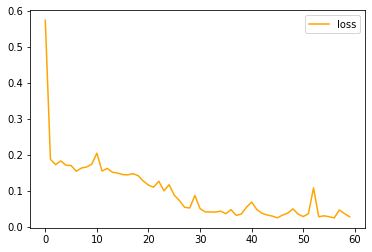

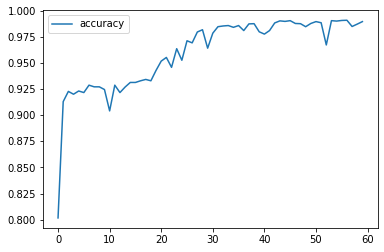

In [33]:
history_data = pd.DataFrame(history.history)
history_data.loc[:,['loss']].plot()
history_data.loc[:,['accuracy']].plot()

In [ ]:
# Salva o modelo treinado
model.save('./modelo99')

<h2>Execução e testes</h2>

In [112]:
# Avaliação do desempenho do modelo
model.evaluate(validation_images)

18/18 [==============================] - 24s 1s/step - loss: 0.0180 - accuracy: 0.9920


[0.017997026443481445, 0.9920070767402649]

Found 5631 files belonging to 4 classes.


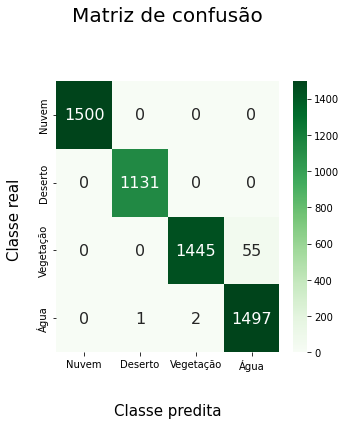

In [174]:
# Matriz de confusão

true = np.array([])
pred = np.array([])

dataset = dataset_from_dir(
    DATASETDIR,
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 256,
    image_size = (256, 256),
    shuffle = False,
    seed = 1,
)


for (i, (data, labels)) in enumerate(dataset):
    true = np.append(true, labels)
    pred = np.append(pred, np.argmax(model.predict(data, verbose=0), axis=1))

cf_matrix = confusion_matrix(true,pred)
df_cf_matrix = pd.DataFrame(cf_matrix, index = [i for i in range(4)],
                  columns = [i for i in range(4)])

fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(df_cf_matrix, cmap="Greens", annot=True, annot_kws={"size": 16},fmt='d')
ax.set_title('Matriz de confusão\n\n',fontdict = {'size':20}, pad = 15)
ax.set_xlabel('\nClasse predita',fontdict = {'size':15}, labelpad = 15)
ax.set_ylabel('Classe real ',fontdict = {'size':15}, labelpad = 15);
ax.set_xticklabels(('Nuvem','Deserto','Vegetação','Água'))
ax.set_yticklabels(('Nuvem','Deserto','Vegetação','Água'))

plt.show()

In [197]:
# Funções para carregar e classificar imagem

# https://github.com/keras-team/keras/blob/07e13740fd181fc3ddec7d9a594d8a08666645f6/keras/utils/image_dataset.py#L258
def load_image(path, image_size, num_channels, interpolation,
               crop_to_aspect_ratio=False):
  """Load an image from a path and resize it."""
  img = tf.io.read_file(path)
  img = tf.image.decode_image(
      img, channels=num_channels, expand_animations=False)
  if crop_to_aspect_ratio:
    img = image_utils.smart_resize(img, image_size, interpolation=interpolation)
  else:
    img = tf.image.resize(img, image_size, method=interpolation)
  img.set_shape((image_size[0], image_size[1], num_channels))
  return img

def predict(image_path):
    prediction = np.argmax(model.predict(np.expand_dims(load_image(image_path, (256, 256), 3, 'bilinear'), axis=0), verbose=0)[0], axis=0)
    return ['nuvem', 'deserto', 'vegetação', 'água'][prediction]


<div style='height: 50px'></div>

<h3>Exemplos de Predições <span style='color: #00BB00'>Corretas</span></h3>

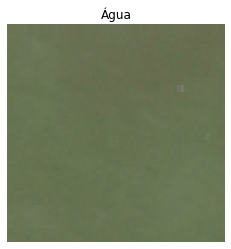

In [228]:
img = r".\%s\water\SeaLake_2351.jpg" % DATASETDIR
plt.imshow(cv2.imread(img)); plt.axis('off'); plt.title('Água'); plt.show()

In [221]:
predict(img)

'água'

<div style='height: 30px'></div>

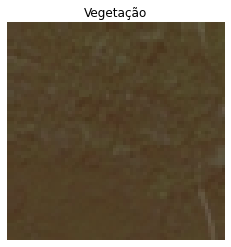

In [229]:
img = r".\%s\green_area\Forest_230.jpg" % DATASETDIR
plt.imshow(cv2.imread(img)); plt.axis('off');plt.title('Vegetação'); plt.show()

In [230]:
predict(img)

'vegetação'

<div style='height: 30px'></div>

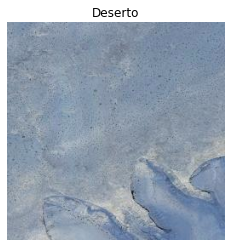

In [238]:
img = r".\%s\desert\desert(2).jpg" % DATASETDIR
plt.imshow(cv2.imread(img)); plt.axis('off'); plt.title('Deserto'); plt.show()

In [239]:
predict(img)

'deserto'

<div style='height: 30px'></div>

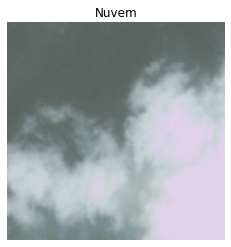

In [244]:
img = r".\%s\cloudy\train_12.jpg" % DATASETDIR
plt.imshow(cv2.imread(img)); plt.axis('off'); plt.title('Nuvem'); plt.show()

In [245]:
predict(img)

'nuvem'

<p style='height: 30px'></p>
<h3>Exemplos de Predições <span style='color: #CC0000'>Incorretas</span></h3>

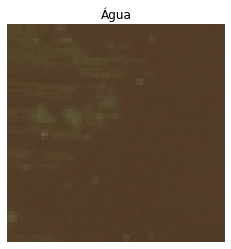

In [247]:
img = r".\%s\water\SeaLake_2359.jpg" % DATASETDIR
plt.imshow(cv2.imread(img)); plt.axis('off'); plt.title('Água'); plt.show()

In [248]:
predict(img)

'vegetação'

<p style='height: 30px'></p>

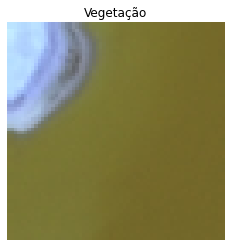

In [262]:
img = r".\%s\water\SeaLake_967.jpg" % DATASETDIR
plt.imshow(cv2.imread(img)); plt.axis('off'); plt.title('Vegetação'); plt.show()

In [263]:
predict(img)

'deserto'

<p style='height: 30px'></p>

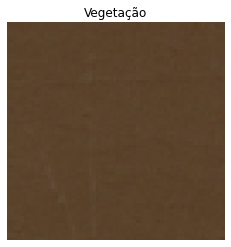

In [255]:
img = r".\%s\green_area\Forest_2047.jpg" % DATASETDIR
plt.imshow(cv2.imread(img)); plt.axis('off'); plt.title('Vegetação'); plt.show()

In [257]:
predict(img)

'água'

<h1>Comparação com outros métodos</h1>

In [25]:
pd.DataFrame({
    'Artigo': [
        '-',
        'Attention GANs: Unsupervised Deep Feature Learning for Aerial Scene Classification',
        'Remote Sensing Image Scene Classification Using CNN-CapsNet',
        'Remote Sensing Scene Classification by Gated Bidirectional Network',
        'Classification of Satellite Images Based on Color Features Using Remote Sensing',
        'Very deep convolutional networks for large-scale image recognition'
    ],
    
    'Ano': [
        2022,
        2020,
        2017,
        2019,
        2018,
        2014
    ],
    
    'Método': [
        'VGG-16 simplificado',
        'Attention Generative Adversarial Networks',
        'CNN-CapsNet',
        'Gated Bidirectional Network',
        'K-Means',
        'VGG Net-D',
        
    ],
    
    'Acurácia': [
        '99%',
        '72%',
        '97%',
        '92%',
        '92%',
        '84%',
    ],
    
    'Base de dados': [
        'RSI-CB256',
        'NWPU-RESISC45',
        'UC Merced',
        'AID',
        'Iraqi GSC',
        'ILSVRC-2012'
    ]
})

,Artigo,Ano,Método,Acurácia,Base de dados
0,-,2022,VGG-16 simplificado,99%,RSI-CB256
1,Attention GANs: Unsupervised Deep Feature Lear...,2020,Attention Generative Adversarial Networks,72%,NWPU-RESISC45
2,Remote Sensing Image Scene Classification Usin...,2017,CNN-CapsNet,97%,UC Merced
3,Remote Sensing Scene Classification by Gated B...,2019,Gated Bidirectional Network,92%,AID
4,Classification of Satellite Images Based on Co...,2018,K-Means,92%,Iraqi GSC
5,Very deep convolutional networks for large-sca...,2014,VGG Net-D,84%,ILSVRC-2012
